# Set up the environment

In [1]:
"""This is the primary code document for the execution of this workflow.
Queries the database for specific genes."""

# Load our packages for the environment
import sys, os
import time
from joblib import Parallel, delayed
from phe import paillier
from p_bloom_filter import encode
from p_database import search, magnitude
from optimize_invert import invert
from Bio import SeqIO
import random
from random import randint
import numpy as np

paillier.invert = invert
num_cores = 48 # Number of cores for parellel processing
query_len = 20000

# Locate the data

In [2]:
base = '/local_data/atitus/data/genomes/' 
f = '/local_data/atitus/data/genomes/bac_queries/query100.fasta'
d = os.path.join(base, 'bacteria/')

In [3]:
random.seed(1)

files = os.listdir(d)
num_files = len(files)
print('Number of files: %s' %str(num_files))

query_file_ind = randint(0, 100)

f = files[query_file_ind]

print('Selected "' + f + '" from file number %s' % str(query_file_ind))

f = os.path.join(d, f)
print(f)

Number of files: 978
Selected "GCF_000561165.1_Stap_aure_T62848_V1_genomic.fasta" from file number 17
/local_data/atitus/data/genomes/bacteria/GCF_000561165.1_Stap_aure_T62848_V1_genomic.fasta


# Read the FASTA sequence file

In [4]:
seq = ''
with open(f, "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq += str(record.seq)

# Vary the % of sequence mutation and calculated max IoU
- We are ranging from 100% mutated to ~0% mutated
- K = 16
- SIZE = 100,000
- SeqSize = 20,000

In [9]:
#out = []
#for prob in np.arange(1, -0.05, -0.05):
#    target_seq = aug_query(seq, prob)
#    result = compare(target_seq, d)
#    result.append(prob)
#    out.append(result)
#    print(prob)

# Pull out the IoUs and whether the max prediction matches the query

In [10]:
correct = [1 if out[i][4] == seq[:1000] else 0 for i,_ in enumerate(out)]
IoUs = [out[i][0] for i,_ in enumerate(out)]
print(correct)
print(IoUs)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
[5.5370985603543746e-05, 0.024464374688589936, 0.04724651694282073, 0.06962220508866615, 0.08584814661705939, 0.09666677443341631, 0.10093852355757117, 0.10175925925925926, 0.10155105031753786, 0.10195445689235265, 0.10204950434835493, 0.10177543624569844, 0.1016086771068186, 0.10329723810682565, 0.10219244823386114, 0.10641608444946152, 0.11433310806659704, 0.13466645836588034, 0.18325939457202506, 0.3379996316080309, 1.0]


# ROC Curve for IoU scores

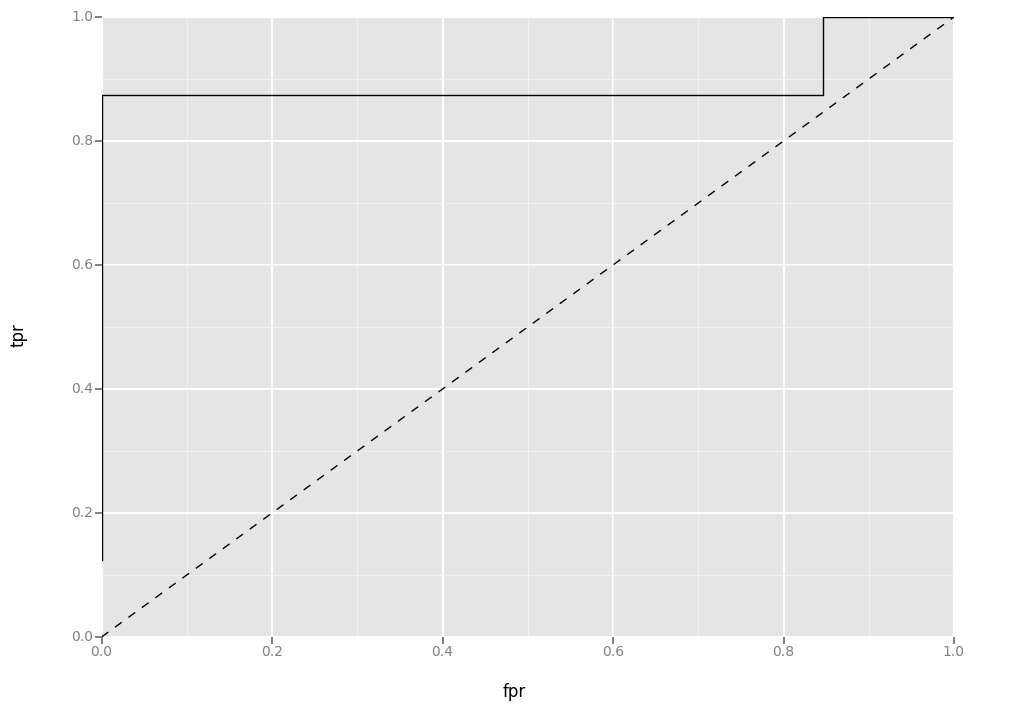

<ggplot: (-9223363280631070204)>

In [8]:
# http://blog.yhat.com/posts/roc-curves.html
from sklearn import metrics
import pandas as pd
from ggplot import *

ytest = correct
preds = IoUs
fpr, tpr, _ = metrics.roc_curve(ytest, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

# Code for analysis

In [5]:
####################
# Augment query to test mutation effect on performance
####################
def aug_query(input_seq, mut_prob):
    query = ''
    probs = [random.uniform(0, 1) for i,_ in enumerate(input_seq)]
    
    query = ''.join(base if probs[i] > mut_prob else 'X' for i,base in enumerate(input_seq))
            
    return query.upper()


####################
# Main function to run pipeline
####################
def compare(seq, d, dev = False):
    
    global query_len
    
    # Create the encryption public and private key pair
    public_key, private_key = paillier.generate_paillier_keypair()

    # Build the query by concatenating the entries in a FASTA file together
    queries = ''
    
    seq = seq[:query_len]
    
    max_iou, max_ioLquery, max_ioLresult, best_seq, best_mag = query(seq, public_key, private_key, dev = dev, data_dir = d)
    
    out = [max_iou, max_ioLquery, max_ioLresult, seq[:1000], best_seq[:1000]]
    return out


        
####################
# Query a database with a query and public key and decrypt using a private key
####################
def query(query, public_key, private_key, dev, data_dir):
    """Encodes a query and searches for it in the data base.

    Args:
        query: A genetic sequence (string) to be searched for.
        public_key: The public key for the paillier encryption.
        private_key: The private key for the paillier encryption.

    Returns:
        The 'Gene' that is the 'best match' to the query.

        The IOU for the 'best match' and the query.
    """
    global num_cores

    query = encode(query)
    query_mag = magnitude(query)
    
    query = Parallel(n_jobs=num_cores)(delayed(public_key.encrypt)(x) for x in query)
    
    scores = search(query, data_dir = data_dir)
    
    max_iou = 0
    best_id = 0
    best_seq = ''
    result_scores = Parallel(n_jobs=num_cores)(delayed(calc_iou)(id_, private_key, query_mag) for id_ in scores)
    
    for score_set in result_scores:
        if score_set[0] >= max_iou: 
            max_iou = score_set[0]
            max_ioLquery = score_set[1]
            max_ioLresult = score_set[2]  
            best_seq = score_set[3]
            result_mag = score_set[4]
                
    return max_iou, max_ioLquery, max_ioLresult, best_seq, result_mag


####################
# Calculate the Intersection over Union
####################
def calc_iou(id_, private_key, query_mag):
    intersection = private_key.decrypt(id_[0])
    Iou, IoLquery, IoLresult = iou(intersection, id_[1], query_mag)
    
    return Iou, IoLquery, IoLresult, id_[2], id_[1]


####################
# Calculate the Intersection over Union
####################
def iou(intersection, data_mag, query_mag):
    """Finds the IOU for two bloom filters.

    Args:
        intersection: The intersection of the two genes.
        data_mag: The magnitude of the gene being compared to.
        query_mag: The magnitude of the gene being searched for.

    Returns:
        The IOU for the two genes.
    """
    union = (data_mag + query_mag) - intersection
    
    iou = intersection/union
    max_ioLquery = intersection/query_mag
    max_ioLresult = intersection/data_mag
    
    return iou, max_ioLquery, max_ioLresult